# Analyse BlueSeis BSPF Event Analysis - Backazimuth

In [1]:
import os,sys
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
from functions.compute_backazimuth import __compute_backazimuth

In [3]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

In [4]:
sys.path.append(root_path+"andbro_python/")

from andbro__store_as_pickle import __store_as_pickle
from andbro__savefig import __savefig

## Configurations

In [5]:
config = {}

## BSPF coordinates
config['BSPF_lon'] = -116.455439
config['BSPF_lat'] = 33.610643

##
config['path_to_mseed'] = data_path+"BSPF/data/waveforms/ACC/"

## event selction
config['path_to_data'] = data_path+"BSPF/data/"

## output path for figures
config['output_figs'] = data_path+"BSPF/figures/baz/"


config['fmin'], config['fmax'] = 0.5, 2.0

## Load Data

In [6]:
events = obs.read_events(config['path_to_data']+"catalogs/BSPF_catalog_20221001_20230930_all.xml")

triggered = pd.read_pickle(config['path_to_data']+"catalogs/BSPF_catalog_20221001_20230930_triggered.pkl")

event_times = pd.read_pickle(config['path_to_data']+"event_selection_good.pkl")

In [7]:
num = 5

event_time = event_times.origin_time.loc[num]

event = events.filter(f"time >= {event_time}",f"time <= {event_time}")

trig = triggered[triggered.origin == event_time]

## prepare string
event_time_str = event_time.split(".")[0].replace(" ","_").replace("-","").replace(":","")

In [8]:
st = obs.read(config['path_to_mseed']+f"*{event_time_str}*")

# st.write("./event42_6c.mseed", format="MSEED")

st = st.resample(40).trim(st[0].stats.starttime, st[0].stats.endtime);

st = st.detrend("linear");

st = st.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True);

In [9]:
# cut_offs = [
#     (70,60), (65,80), (60,100), (60,100), (60,70),
#     (60,90), (60,90), (60,90), (62,105), (65,90),
#     (62,110), (65,85), (60,105), (63,105), (66,90),
#     (60,90), (65,90), (70,95),
# ]

# # st.trim(st[0].stats.starttime+cut_offs[num][0]-10, st[0].stats.endtime-cut_offs[num][1]+10);
# st.trim(st[0].stats.starttime+cut_offs[num][0], st[0].stats.endtime-cut_offs[num][1]);

In [10]:
# st.plot(equal_scale=False);

## BAZ Estimation for One Event

In [11]:
config['station_longitude'] = config['BSPF_lon']
config['station_latitude']  = config['BSPF_lat']

config['eventtime'] = event_time

config['tbeg'], config['tend'] = st[0].stats.starttime, st[0].stats.endtime

## specify window length for baz estimation in seconds
# config['win_length_sec'] = 1/config['fmin']
config['win_length_sec'] = 1

## define an overlap for the windows in percent (50 -> 50%)
config['overlap'] = 50

## specify steps for degrees of baz
config['step'] = 1



 -> event used for theoretical backazimuth:
 ->  earthquake name :  16 km N of Borrego Springs, CA

 -> Epicentral distance [m]:       24334.6
 -> Theoretical azimuth [deg]:     346.3
 -> Theoretical backazimuth [deg]: 166.3

 -> using love waves for estimation ...


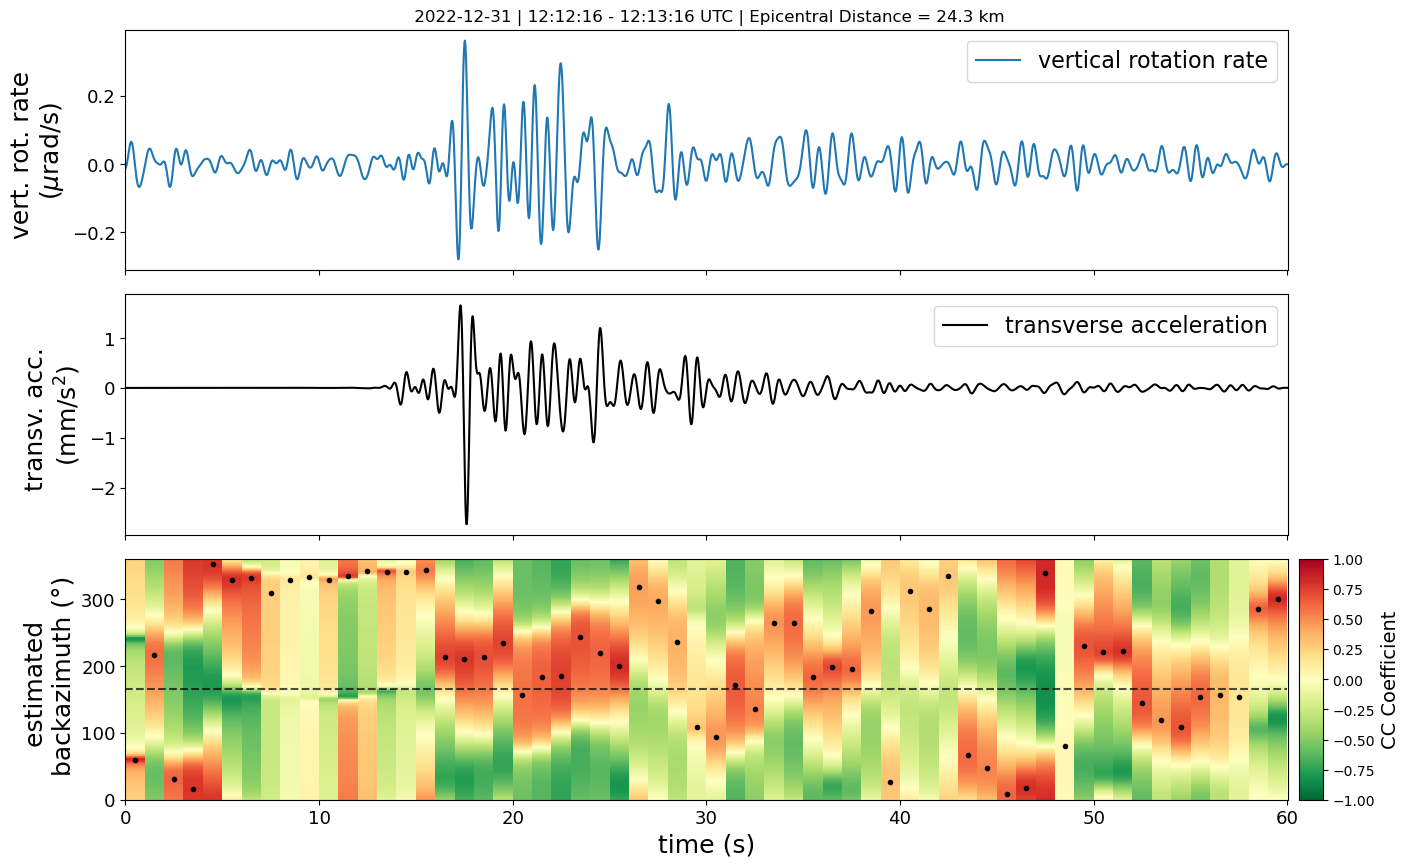

 -> event used for theoretical backazimuth:
 ->  earthquake name :  16 km N of Borrego Springs, CA

 -> Epicentral distance [m]:       24334.6
 -> Theoretical azimuth [deg]:     346.3
 -> Theoretical backazimuth [deg]: 166.3

 -> using rayleigh waves for estimation ...


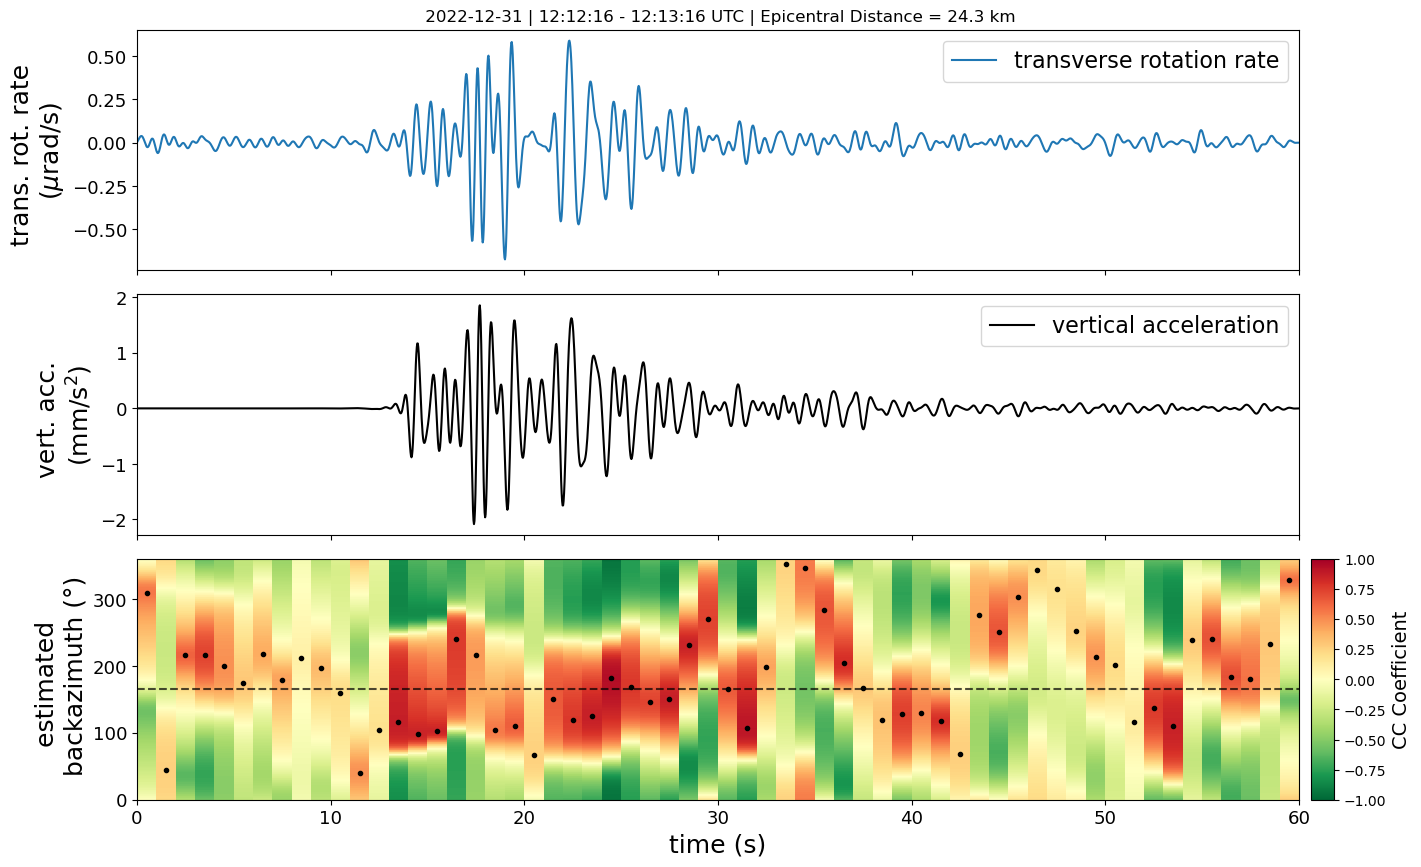

In [12]:
acc = st.select(station="PFO*")
rot = st.select(station="BSPF")
# rot = st.select(station="RPFO", location="in")
# rot = st.select(station="RPFO", location="mi")
# rot = st.select(station="RPFO", location="al")

# acc.select(channel="*Z")[0].data *= -1
# acc.select(channel="*N")[0].data *= -1
# acc.select(channel="*E")[0].data *= -1


config['type'] = "love" ## "love" | "rayleigh"
out = __compute_backazimuth(acc, rot, config, wave_type=config['type'], event=event[0], plot=True, show_details=True)
# __savefig(out['fig'], config['output_figs'], f"{event_time_str}_baz_{config['type']}", mode="png", dpi=200)

config['type'] = "rayleigh"
out = __compute_backazimuth(acc, rot, config, wave_type=config['type'], event=event[0], plot=True, show_details=True)
# __savefig(out['fig'], config['output_figs'], f"{event_time_str}_baz_{config['type']}", mode="png", dpi=200)

### Tanges

In [13]:
from functions.compute_backazimuth_tangent import __compute_backazimuth_tangent

In [14]:
acc = st.select(station="PFO*")
rot = st.select(station="BSPF")

# rot = st.select(station="RPFO", location="in")
# rot = st.select(station="RPFO", location="mi")
# rot = st.select(station="RPFO", location="al")

In [15]:
# def __baz_tangent(rot0, acc0, win_time_s=0.5, overlap=0.5, baz_theo=None, cc_thres=None, plot=False):

#     from numpy import zeros, nan, ones, nanmean, array, nanmax
#     from numpy import arctan, pi, linspace, cov, argsort, corrcoef, correlate
#     from obspy.signal.rotate import rotate_ne_rt
#     from numpy.linalg import eigh
#     from obspy.signal.cross_correlation import correlate

#     npts = rot0[0].stats.npts

#     df = rot0[0].stats.sampling_rate

#     ## windows
#     t_win = win_time_s
#     n_win = int(win_time_s*df)
#     nover = int(overlap*n_win)

#     ## extract components
#     rot_n = rot.select(channel="*N")[0].data
#     rot_e = rot.select(channel="*E")[0].data
#     acc_z = rot.select(channel="*Z")[0].data

#     ## define windows
#     n, windows = 0, []
#     while n < npts-n_win:
#         windows.append((n,n+n_win))
#         n+=n_win


#     ## add overlap
#     if overlap != 0:
#         windows_overlap = []
#         for i, w in enumerate(windows):
#             if i == 0:
#                 windows_overlap.append((w[0],w[1]+nover))
#             elif i >= int(len(windows)-nover):
#                 windows_overlap.append((w[0]-nover, w[1]))
#             else:
#                 windows_overlap.append((w[0]-nover, w[1]+nover))
#     else:
#         windows_overlap = windows

#     ## compute baz and ccorr for each window
#     baz, ccor = ones(len(windows_overlap))*nan, ones(len(windows_overlap))*nan

#     for j, (w1, w2) in enumerate(windows_overlap):

#         if int(w2-w1) < 10:
#             print(f" -> not enough samples in window (<10)")

#         dat = (zeros((len(rot_n[w1:w2]), 2)))
#         dat[:,0] = rot_e[w1:w2]
#         dat[:,1] = rot_n[w1:w2]

#         covar = cov(dat, rowvar=False)

#         Cprime, Q = eigh(covar, UPLO='U')

#         loc = argsort(abs(Cprime))[::-1]

#         Q = Q[:,loc]

#         baz0 = -arctan((Q[1,0]/Q[0,0]))*180/pi

#         if baz0 <= 0:
#             baz0 += 180
#         ## __________________________
#         ## remove 180° ambiguity

#         rot_r, rot_t = rotate_ne_rt(rot_n[w1:w2], rot_e[w1:w2], baz0)

# #         corr_baz = corrcoef(acc_z[w1:w2], rot_t)[0][1]
#         corr_baz = correlate(acc_z[w1:w2], rot_t, 0, 'auto')[0]


#         if (corr_baz > 0):
#             baz0 += 180

#         ## add new values to array
#         if corr_baz > cc_thres:
#             baz[j] = baz0
#             ccor[j] = corr_baz

#     ## define time axis
#     t1 = array([w1/df for (w1, w2) in windows_overlap])
#     t2 = array([w2/df for (w1, w2) in windows_overlap])

#     time = array([((w2-w1)/2+w1)/df for (w1, w2) in windows_overlap])
#     terr = (t2-t1)/2

#     if plot:

#         rot0, acc0 = rot_n, acc_z

#         cmap = plt.get_cmap("viridis", 10)

#         fig, ax = plt.subplots(1,1,figsize=(15,5))

#         ax.plot(array(range(len(rot0)))/df, rot0/max(abs(rot0)), alpha=1, color="grey", label="rotation rate (rad/s)")
#         ax.plot(array(range(len(acc0)))/df, acc0/max(abs(acc0)), alpha=0.5, color="tab:red", label="acceleration (m/s)")


#         ax.set_ylim(-1,1)
#         ax.set_xlim(0, len(rot0)/df)
#         ax.set_xlabel("Time (s)",fontsize=14)
#         ax.set_ylabel("Norm. Amplitude",fontsize=14)
#         ax.grid(zorder=0)
#         ax.legend(loc=4, fontsize=13)

#         ax2 = ax.twinx()
#         cax = ax2.scatter(time, baz, c=ccor, s=50, cmap=cmap, edgecolors="k", lw=1, vmin=0, vmax=1, zorder=2)
#         ax2.errorbar(time, baz, xerr=terr, yerr=None, zorder=1, color="lightgrey", marker='o', markersize=2, ls="None")
#         ax2.set_ylabel("Backazimuth (°)", fontsize=14)
#         ax2.set_ylim(0, 360)
#         ax2.set_yticks(np.linspace(ax2.get_yticks()[0], ax2.get_yticks()[-1], len(ax.get_yticks())))

#         cbar = plt.colorbar(cax, pad=0.08)
#         cbar.set_label("Cross-Correlation Coefficient", fontsize=14)

#         cax.set_clip_on(False)

#         if baz_theo:
#             ax2.axhline(baz_theo, ls=":",c="k")

#         plt.show();

#         out = {"time":time, "baz_est":baz, "ccoef":ccor, "baz_theo":baz_theo, "fig":fig}
#     else:
#         out = {"time":time, "baz_est":baz, "ccoef":ccor, "baz_theo":baz_theo}

#     return out

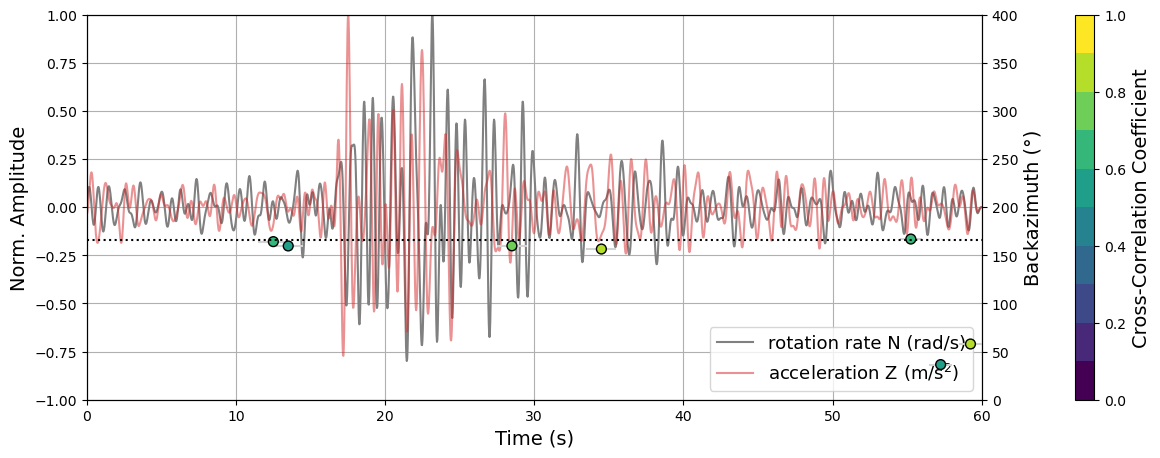

In [16]:
out = __compute_backazimuth_tangent(rot, acc, win_time_s=1, overlap=0.5, baz_theo=trig.backazimuth.iloc[0], cc_thres=0.5, plot=True)

## Compare Baz-Estimates

In [17]:
from functions.compare_backazimuth_codes import __compare_backazimuth_codes

In [18]:
acc = st.select(station="PFO*").copy();
rot = st.select(station="BSPF").copy();

out = __compare_backazimuth_codes(rot, acc, event[0], config['fmin'], config['fmax'], plot=False)

# out['fig'].savefig(config['path_to_figs']+f"BSPF_M42_baz_comparison_{fmin}_{fmax}.png", dpi=200, bbox_inches='tight', pad_inches=0.05);

NameError: name 'np' is not defined

## AS LOOP

In [ ]:
def __makeplot_baz_compare(st0, cat_event, fmin, fmax, plot=False):

    import matplotlib.pyplot as plt
    from numpy import ones, linspace, histogram, concatenate, average, argmax, isnan

    st = st0.copy()

    st.sort(keys=['channel'], reverse=True)

    acc = st.select(station="PFO*")
    rot = st.select(station="BSPF")

    rot.detrend("demean").taper(0.1).filter("bandpass", freqmin=fmin, freqmax=fmax, zerophase=True, corners=8)
    acc.detrend("demean").taper(0.1).filter("bandpass", freqmin=fmin, freqmax=fmax, zerophase=True, corners=8)

    config = {}

    config['tbeg'] = st[0].stats.starttime
    config['tend'] = st[0].stats.endtime

    ## Eventtime
    config['eventtime'] = obs.UTCDateTime(cat_event.origins[0].time)

    ## specify coordinates of station
    config['station_longitude'] =  -116.455439
    config['station_latitude']  = 33.6106

    ## specify window length for baz estimation in seconds
    config['win_length_sec'] = 1/fmin

    ## define an overlap for the windows in percent (50 -> 50%)
    config['overlap'] = 50

    ## specify steps for degrees of baz
    config['step'] = 1


    out1 = __compute_backazimuth(
                                acc,
                                rot,
                                config,
                                wave_type='rayleigh',
                                event=cat_event,
                                plot=False,
                                flim=(fmin, fmax),
                                show_details=False,
    )

    out2 = __compute_backazimuth(
                                acc,
                                rot,
                                config,
                                wave_type='love',
                                event=cat_event,
                                plot=False,
                                flim=(fmin, fmax),
                                show_details=False,
    )

    out3 = __compute_backazimuth_tangent(
                                        rot,
                                        acc,
                                        win_time_s= config['win_length_sec'],
                                        overlap=config['overlap']/100,
                                        baz_theo=out2['baz_theo'],
                                        cc_thres=-1,
                                        plot=False,
    )


    if plot:

        NN = 6
        rot_scaling, rot_unit = 1e6, r"$\mu$rad/s"
        trans_scaling, trans_unit = 1e3, r"mm/s$^2$"

        font = 12

        fig, ax = plt.subplots(NN, 1, figsize=(15,10), sharex=True)

        plt.subplots_adjust(hspace=0.2)

        hz = st.select(channel="*HZ")[0]
        hn = st.select(channel="*HN")[0]
        he = st.select(channel="*HE")[0]

        jz = st.select(channel="*JZ")[0]
        jn = st.select(channel="*JN")[0]
        je = st.select(channel="*JE")[0]

        t1, t2 = hz.times().min(), hz.times().max()

        ax[0].plot(hz.times(), hz.data*trans_scaling, 'black', label=f"XPFO.Z")
        ax[1].plot(hn.times(), hn.data*trans_scaling, 'black', label=f"XPFO.N")
        ax[2].plot(he.times(), he.data*trans_scaling, 'black', label=f"XPFO.E")

        ax[0].set_ylim(-max(abs(hz.data*trans_scaling)), max(abs(hz.data*trans_scaling)))
        ax[1].set_ylim(-max(abs(hn.data*trans_scaling)), max(abs(hn.data*trans_scaling)))
        ax[2].set_ylim(-max(abs(he.data*trans_scaling)), max(abs(he.data*trans_scaling)))

        ax00 = ax[0].twinx()
        ax00.plot(jz.times(), jz.data*rot_scaling, 'darkred', label=r"BSPF.Z")

        ax11 = ax[1].twinx()
        ax11.plot(jn.times(), jn.data*rot_scaling, 'darkred', label=r"BSPF.N")

        ax22 = ax[2].twinx()
        ax22.plot(je.times(), je.data*rot_scaling, 'darkred', label=r"BSPF.E")

        ax00.set_ylim(-max(abs(jz.data*rot_scaling)), max(abs(jz.data*rot_scaling)))
        ax11.set_ylim(-max(abs(jn.data*rot_scaling)), max(abs(jn.data*rot_scaling)))
        ax22.set_ylim(-max(abs(je.data*rot_scaling)), max(abs(je.data*rot_scaling)))

        cmap = plt.get_cmap("viridis", 10)

        ca3 = ax[3].scatter(out1['cc_max_t'], out1['cc_max_y'], c=out1['cc_max'], s=50, cmap=cmap, edgecolors="k", lw=1, vmin=0, vmax=1, zorder=2)
        ax[3].plot([t1, t2], ones(2)*out1['baz_theo'], lw=1.5, alpha=0.7, color="k", ls="--", zorder=1)

        ca4 = ax[4].scatter(out2['cc_max_t'], out2['cc_max_y'], c=out2['cc_max'], s=50, cmap=cmap, edgecolors="k", lw=1, vmin=0, vmax=1, zorder=2)
        ax[4].plot([t1, t2], ones(2)*out2['baz_theo'], lw=1.5, alpha=0.7, color="k", ls="--", zorder=1)

        ca5 = ax[5].scatter(out3['t_win_center'], out3['baz_est'], c=out3['ccoef'], s=50, cmap=cmap, edgecolors="k", lw=1, vmin=0, vmax=1, zorder=2)
        ax[5].plot([t1, t2], ones(2)*out3['baz_theo'], lw=1.5, alpha=0.7, color="k", ls="--", zorder=1)

        cax3 = ax[3].inset_axes([1.01, 0., 0.02, 1])
        cb3 = plt.colorbar(ca3, ax=ax[3], cax=cax3)
        cb3.set_label("CC-Coeff.", fontsize=font)

        cax4 = ax[4].inset_axes([1.01, 0., 0.02, 1])
        cb4 = plt.colorbar(ca4, ax=ax[4], cax=cax4)
        cb4.set_label("CC-Coeff.", fontsize=font)

        cax5 = ax[5].inset_axes([1.01, 0., 0.02, 1])
        cb5 = plt.colorbar(ca5, ax=ax[5], cax=cax5)
        cb5.set_label("CC-Coeff.", fontsize=font)

        ax[3].set_ylabel(f"Rayleigh Baz.(°)")
        ax[4].set_ylabel(f"Love Baz.(°)")
        ax[5].set_ylabel(f"CoVar. Baz.(°)")


        ax[0].set_yticks(linspace(ax[0].get_yticks()[0], ax[0].get_yticks()[-1], len(ax[0].get_yticks())))
        ax00.set_yticks(linspace(ax00.get_yticks()[0], ax00.get_yticks()[-1], len(ax[0].get_yticks())))

        ax[1].set_yticks(linspace(ax[1].get_yticks()[0], ax[1].get_yticks()[-1], len(ax[1].get_yticks())))
        ax11.set_yticks(linspace(ax11.get_yticks()[0], ax11.get_yticks()[-1], len(ax[1].get_yticks())))

        ax[2].set_yticks(linspace(ax[2].get_yticks()[0], ax[2].get_yticks()[-1], len(ax[2].get_yticks())))
        ax22.set_yticks(linspace(ax22.get_yticks()[0], ax22.get_yticks()[-1], len(ax[2].get_yticks())))

        for i in [0,1,2]:
            ax[i].grid(which="both", ls=":", alpha=0.7, color="grey", zorder=0)
            ax[i].legend(loc=1)
            ax[i].set_ylabel(f"a ({trans_unit})")

        for i in [3,4,5]:
            ax[i].set_ylim(-5, 365)
            ax[i].set_yticks(range(0,360+60,60))
            ax[i].grid(which="both", ls=":", alpha=0.7, color="grey", zorder=0)
            # ax[i].set_ylabel(f"Baz.(°)")

        for aaxx in [ax00, ax11, ax22]:
            aaxx.tick_params(axis='y', colors="darkred")
            aaxx.set_ylabel(f"$\omega$ ({rot_unit})", color="darkred")
            aaxx.legend(loc=4)

        ax[0].set_title(f" {config['tbeg'].date}  {str(config['tbeg'].time).split('.')[0]}-{str(config['tend'].time).split('.')[0]} UTC | f = {fmin}-{fmax} Hz | T = {config['win_length_sec']} s | {config['overlap']} % ")

        plt.show();



    ## compute statistics
    deltaa = 5
    angles = np.arange(0, 365, deltaa)


    ## Rayleigh
    hist = histogram(out1['cc_max_y'], bins=len(angles)-1, range=[min(angles), max(angles)], weights=out1['cc_max'], density=True)

    baz_rayleigh_mean = round(average(out1['cc_max_y'][~isnan(out1['cc_max_y'])], weights=out1['cc_max'][~isnan(out1['cc_max'])]), 0)
    baz_rayleigh_max = angles[argmax(hist[0])]+deltaa  ## add half of deltaa to be in the bin center

    ## Love
    hist = histogram(out2['cc_max_y'], bins=len(angles)-1, range=[min(angles), max(angles)], weights=out2['cc_max'], density=True)

    baz_love_mean = round(average(out2['cc_max_y'][~isnan(out2['cc_max_y'])], weights=out2['cc_max'][~isnan(out2['cc_max'])]), 0)
    baz_love_max = angles[argmax(hist[0])]+deltaa  ## add half of deltaa to be in the bin center

    ## Tangent
    hist = histogram(out3['baz_est'], bins=len(angles)-1, range=[min(angles), max(angles)], weights=out3['ccoef'], density=True)

    baz_tangent_mean = round(average(out3['baz_est'][~isnan(out3['baz_est'])], weights=out3['ccoef'][~isnan(out3['ccoef'])]), 0)
    baz_tangent_max = angles[argmax(hist[0])]+deltaa  ## add half of deltaa to be in the bin center


    out = {}
    out['baz_theo'] = round(out2['baz_theo'], 0)
    out['baz_angles'] = angles
    out['baz_tangent_max'] = baz_tangent_max
    out['baz_tangent_mean'] = baz_tangent_mean
    out['baz_rayleigh_max'] = baz_rayleigh_max
    out['baz_rayleigh_mean'] = baz_rayleigh_mean
    out['baz_love_max'] = baz_love_max
    out['baz_love_mean'] = baz_love_mean


    if plot:
        out['fig'] = fig

    return out

In [ ]:
config['station_longitude'] = config['BSPF_lon']
config['station_latitude']  = config['BSPF_lat']

# config['eventtime'] = event_time


## define an overlap for the windows in percent (50 -> 50%)
config['overlap'] = 90

## specify steps for degrees of baz
config['step'] = 1

config['fmin'], config['fmax'] = 8.0, 12.0

# config['cc_thres'] = 0.2

# config['rot_name'] = "bspf"  ## "iadr"; "bspf"

## specify window length for baz estimation in seconds
config['win_length_sec'] = 1/config['fmin']

data = {}

first=True

for i in range(0, 17):

    event_time = event_times.origin_time.loc[i]

    ## load event data
    try:
        event = events.filter(f"time >= {event_time}", f"time <= {event_time}")
        trig = triggered[triggered.origin == event_time]
    except:
        print(f" -> {i} no event in catalog")


    ## prepare string
    event_time_str = event_time.split(".")[0].replace(" ","_").replace("-","").replace(":","")


    ## load waveform data
    try:
        st = obs.read(config['path_to_mseed']+f"*{event_time_str}*");
    except:
        print(f" -> {i}: failed to load data")
        continue

    st = st.resample(40).trim(st[0].stats.starttime, st[0].stats.endtime);
    st = st.detrend("simple");
    st = st.taper(0.01);
    st = st.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True);

    # st = st.trim(st[0].stats.starttime+cut_offs[i][0]-10, st[0].stats.endtime-cut_offs[i][1]+10);

    acc = st.select(station="PFO*").copy();
    rot = st.select(station="BSPF").copy();


    config['tbeg'], config['tend'] = rot[0].stats.starttime, rot[0].stats.endtime

    out = __makeplot_baz_compare(st, event[0], config['fmin'], config['fmax'], plot=True);

    data[i] = out

# df_baz.to_pickle(config['path_to_data']+f"bspf_baz_estimates_{config['rot_name']}.pkl")
# print(f" -> writing: {config['path_to_data']}BSPF_baz_estimates_{config['rot_name']}.pkl")

In [ ]:
# data_baz = df_baz

# x = np.arange(1,len(data_baz.event_time)+1)

# plt.figure(figsize=(15,5))
# plt.scatter(x, data_baz.baz_theo, c="k", zorder=3, label="Baz. theo.")
# # plt.scatter(np.arange(1,len(data_baz.event_time)+1), data_baz.baz_mean)
# plt.errorbar(x, data_baz.baz_mean, yerr=data_baz.baz_std, capsize=7, fmt="o", c="tab:red", zorder=2, label="Baz. mean")

# plt.xticks(np.arange(1,18))
# plt.yticks(np.arange(0,390,30))
# plt.ylim(0, 360)

# plt.xlabel("Event No.")
# plt.ylabel("Backazimuth (°)")
# plt.legend(loc=3)
# plt.grid(alpha=0.5, zorder=-1)

# plt.show();

## Loop OLD

In [ ]:
config['station_longitude'] = config['BSPF_lon']
config['station_latitude']  = config['BSPF_lat']

# config['eventtime'] = event_time

## specify window length for baz estimation in seconds
config['win_length_sec'] = 0.5

## define an overlap for the windows in percent (50 -> 50%)
config['overlap'] = 50

## specify steps for degrees of baz
config['step'] = 1

config['fmin'], config['fmax'] = 0.5, 2.0

config['cc_thres'] = 0.5

config['rot_name'] = "bspf"  ## "iadr"; "bspf"

first=True
for i in range(0, 17):

    event_time = event_times.origin_time.loc[i]

    try:
        event = events.filter(f"time >= {event_time}", f"time <= {event_time}")
        trig = triggered[triggered.origin == event_time]
    except:
        print(f" -> {i} no event in catalog")


    ## prepare string
    event_time_str = event_time.split(".")[0].replace(" ","_").replace("-","").replace(":","")
    try:
        st = obs.read(config['path_to_mseed']+f"*{event_time_str}*");
    except:
        print(f" -> {i}: failed to load data")
        continue

    st = st.resample(40).trim(st[0].stats.starttime, st[0].stats.endtime);

    st = st.detrend("simple");
    st = st.taper(0.01);
    st = st.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True);

    # st = st.trim(st[0].stats.starttime+cut_offs[i][0]-10, st[0].stats.endtime-cut_offs[i][1]+10);

    acc = st.select(station="PFO*").copy();

    if config['rot_name'] == "bspf":
        rot = st.select(station="BSPF").copy();
    elif config['rot_name'] == "iadr":
        rot = st.select(station="RPFO", location="in").copy(); #rot.select(channel="*Z")[0].data *= -1

    config['tbeg'], config['tend'] = rot[0].stats.starttime, rot[0].stats.endtime

    ## RAYLEIGH
    config['type'] = "rayleigh"
    # out = __compute_backazimuth(acc, rot, config, wave_type=config['type'], event=event[0], plot=True, show_details=False)
    # __savefig(out['fig'], config['output_figs'], f"{event_time_str}_baz_{config['type']}", mode="png", dpi=200)

    ## LOVE
    config['type'] = "love"
    # out = __compute_backazimuth(acc, rot, config, wave_type=config['type'], event=event[0], plot=True, show_details=False)
    # __savefig(out['fig'], config['output_figs'], f"{event_time_str}_baz_{config['type']}", mode="png", dpi=200)


    ## TAGENT
    out = __compute_backazimuth_tangent(rot, acc, win_time_s=config['win_length_sec'], overlap=config['overlap']/100,
                                        cc_thres=config['cc_thres'], baz_theo=trig.backazimuth.iloc[0], plot=False)
    # __savefig(out['fig'], config['output_figs'], f"{event_time_str}_baz_tangent", mode="png", dpi=200)

    _baz = {}
    _baz['event_time'] = event_time
    _baz['event_num'] = num
    _baz['baz_mean'] = np.nanmean(out["baz_est"])
    _baz['baz_median'] = np.nanmedian(out["baz_est"])
    _baz['cc_thres'] = config['cc_thres']
    _baz['baz_theo'] = out["baz_theo"]
    _baz['baz_std'] = np.nanstd(out['baz_est'])
    _baz['percentile_05'] = np.nanpercentile(out['baz_est'], [5])
    _baz['percentile_90'] = np.nanpercentile(out['baz_est'], [90])
    _baz['samples'] = len(out['ccoef']) - np.isnan(out['ccoef']).sum()
    _baz['edist_km'] = trig.distances_km.iloc[0]

    if first:
        first=False
        df_baz = pd.DataFrame([_baz])
    else:
        df_baz.loc[len(df_baz)] = _baz

df_baz.to_pickle(config['path_to_data']+f"bspf_baz_estimates_{config['rot_name']}.pkl")
print(f" -> writing: {config['path_to_data']}BSPF_baz_estimates_{config['rot_name']}.pkl")

In [ ]:
data_baz = df_baz

x = np.arange(1,len(data_baz.event_time)+1)

plt.figure(figsize=(15,5))
plt.scatter(x, data_baz.baz_theo, c="k", zorder=3, label="Baz. theo.")
# plt.scatter(np.arange(1,len(data_baz.event_time)+1), data_baz.baz_mean)
plt.errorbar(x, data_baz.baz_mean, yerr=data_baz.baz_std, capsize=7, fmt="o", c="tab:red", zorder=2, label="Baz. mean")

plt.xticks(np.arange(1,18))
plt.yticks(np.arange(0,390,30))
plt.ylim(0, 360)

plt.xlabel("Event No.")
plt.ylabel("Backazimuth (°)")
plt.legend(loc=3)
plt.grid(alpha=0.5, zorder=-1)

plt.show();

In [ ]:
def __polar_plot(data1):

    r1 = data1.edist_km

    theta1 = np.radians(data1.baz_mean)
    theta2 = np.radians(data1.baz_theo)

    err = data1.baz_std

    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8,8))

    ax.set_theta_offset(np.pi/2)
    ax.set_theta_direction(-1)

    m1 = ax.scatter(theta1, r1, s=40, c="tab:red", marker="o", lw=0.5, edgecolors="k", zorder=3)
    m1.set_facecolor('none')

    ax.scatter(theta2, r1, s=40, c="darkgrey", lw=0.5, edgecolors="k", zorder=2)

    for i in range(len(r1)):
        ax.plot([theta1[i], theta2[i]], [r1[i], r1[i]], c="k", zorder=1, alpha=0.5, ls=":")

    # ax.bar(theta1, r1, width=err/200, bottom=0.0, color="b", alpha=0.5)
    ax.errorbar(theta1, r1, xerr=err/100, yerr=None, capsize=7, fmt="o", c="tab:red")

    ## station
    ax.scatter(0, 0, zorder=3, s=100, marker='^', c="r", lw=0.8, edgecolors="k")

#     ax.set_rmax(2)

#     ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
    ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
    ax.grid(True, zorder=0)

    ax.set_title("", va='bottom')
    plt.show()

In [ ]:
__polar_plot(df_baz)

In [ ]:

config['station_longitude'] = config['BSPF_lon']
config['station_latitude']  = config['BSPF_lat']
config['eventtime'] = event_time

## specify window length for baz estimation in seconds
config['win_length_sec'] = 0.3

## define an overlap for the windows in percent (50 -> 50%)
config['overlap'] = 50

## specify steps for degrees of baz
config['step'] = 1

# config['fmin'], config['fmax'] = 8, 15

config['cc_thres'] = 0.4

for fmin, fmax in ([(1,5), (4,8), (8,12), (10,15)]):

    config['fmin'], config['fmax'] = fmin, fmax

    config['win_length_sec'] = 1/config['fmin']

    for rot_name in ["bspf","iadr"]:

            for i in range(0, 17):

                event_time = event_times.origin_time.loc[i]

                try:
                    event = events.filter(f"time >= {event_time}",f"time <= {event_time}")
                    trig = triggered[triggered.origin == event_time]
                except:
                    print(f" -> {i} no event in catalog")


                ## prepare string
                event_time_str = event_time.split(".")[0].replace(" ","_").replace("-","").replace(":","")

                st = obs.read(config['path_to_mseed']+f"*{event_time_str}*");
                st = st.resample(40).trim(st[0].stats.starttime, st[0].stats.endtime);

                st = st.detrend("simple");
                st = st.taper(0.01);
                st = st.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True);

                st = st.trim(st[0].stats.starttime+cut_offs[i][0]-10, st[0].stats.endtime-cut_offs[i][1]+10);

                acc = st.select(station="PFO*").copy();

                ## TAGENT

                if rot_name == "iadr":
                    rot = st.select(station="RPFO", location="in").copy(); #rot.select(channel="*Z")[0].data *= -1
                elif rot_name == "bspf":
                    rot = st.select(station="BSPF").copy();

                config['tbeg'], config['tend'] = rot[0].stats.starttime, rot[0].stats.endtime

                out = __baz_tangent(rot, acc, win_time_s=config['win_length_sec'], overlap=config['overlap']/100,
                                    cc_thres=config['cc_thres'], baz_theo=trig.backazimuth.iloc[0], plot=False)
                # __savefig(out['fig'], config['output_figs'], f"{event_time_str}_baz_tangent", mode="png", dpi=200)

                _baz = {}
                _baz['event_time'] = event_time
                _baz['event_num'] = num
                _baz['baz_mean'] = np.nanmean(out["baz_est"])
                _baz['baz_median'] = np.nanmedian(out["baz_est"])
                _baz['cc_thres'] = config['cc_thres']
                _baz['baz_theo'] = out["baz_theo"]
                _baz['baz_std'] = np.nanstd(out['baz_est'])
                _baz['percentile_05'] = np.nanpercentile(out['baz_est'], [5])
                _baz['percentile_90'] = np.nanpercentile(out['baz_est'], [90])
                _baz['samples'] = len(out['ccoef']) - np.isnan(out['ccoef']).sum()
                _baz['edist_km'] = trig.distances_km.iloc[0]

                if i == 0:
                    df_baz = pd.DataFrame([_baz])
                else:
                    df_baz.loc[len(df_baz)] = _baz

            df_baz.to_pickle(config['path_to_data']+"baz_test/"+f"bspf_baz_estimates_{rot_name}_{fmin}_{fmax}.pkl")
            print(f" -> writing: {config['path_to_data']}"+"baz_test/"+f"bspf_baz_estimates_{rot_name}_{fmin}_{fmax}.pkl")


In [ ]:
fig = plt.figure(figsize=(15,5))

files = os.listdir(config['path_to_data']+"baz_test/")
files.sort()

for n, file in enumerate(files):
    dat = pd.read_pickle(config['path_to_data']+"baz_test/"+file)

    names = file.split(".")[0].split("_")

    colors = {"1":"tab:blue", "4":"tab:orange", "8":"tab:green", "10":"tab:red", "7":"tab:pink"}

    data_baz = dat

    x = np.arange(1,len(data_baz.event_time)+1)



    if names[3] == "bspf":
        plt.scatter(x-.1, data_baz.baz_mean, marker='^', color='None', edgecolors=colors[names[4]], zorder=3, label=f"{names[3]} ({names[4]}-{names[5]}Hz)")
    elif names[3] == "iadr":
        plt.scatter(x+.1, data_baz.baz_mean, marker='s', color='None', edgecolors=colors[names[4]], zorder=3, label=f"{names[3]} ({names[4]}-{names[5]}Hz)")
    elif names[3] == "oadr":
        plt.scatter(x, data_baz.baz_mean, marker='x', color='None', edgecolors=colors[names[4]], zorder=3, label=f"{names[3]} ({names[4]}-{names[5]}Hz)")


plt.xticks(np.arange(1,18))
plt.yticks(np.arange(0,390,30))
plt.ylim(0, 360)

plt.xlabel("Event No.")
plt.ylabel("Backazimuth (°)")
plt.legend(ncol=2)

plt.scatter(x, data_baz.baz_theo, c="k", zorder=3, label="Baz. theo.")

plt.grid(zorder=-1, alpha=0.5)
plt.show();

# fig.savefig(config['output_figs']+"Compare_backazimuth_in_frequency_bands.png", format="png", dpi=200, bbox_inches='tight');

## Test

In [ ]:
data_baz = pd.read_pickle(config['path_to_data']+"bspf_baz_estimates.pkl")
data_baz_adr = pd.read_pickle(config['path_to_data']+"iadr_baz_estimates.pkl")

In [ ]:
def __makeplot1():

    x = np.arange(1,len(data_baz.event_time)+1)

    fig = plt.figure(figsize=(15,5))
    plt.scatter(x, data_baz.baz_theo, c="k", zorder=3, label="Baz. theo.")

    plt.scatter(x-0.1, data_baz.baz_mean, s=data_baz.samples+5, c="tab:red", zorder=3, edgecolors="k")
    plt.errorbar(x-0.1, data_baz.baz_mean, yerr=data_baz.baz_std, ms=0, capsize=7, fmt="o", c="tab:red", zorder=2, label="Baz. mean (BSPF)")

    plt.scatter(x+0.1, data_baz_adr.baz_mean, s=data_baz_adr.samples+5, c="tab:blue", zorder=3, edgecolors="k")
    plt.errorbar(x+0.1, data_baz_adr.baz_mean, yerr=data_baz_adr.baz_std, ms=0, capsize=7, fmt="o", c="tab:blue", zorder=2, label="Baz. mean (ADR)")

    plt.xlabel("Event No.")
    plt.ylabel("Backazimuth (°)")
    plt.legend(loc=3)
    plt.grid(zorder=-1, axis="y")
    plt.show();


__makeplot1()

#     fig.savefig(config['path_to_figs']+"BSPF_baz_events_bspf_adr.png", format="png", dpi=200)
#     fig.savefig(config['path_to_figs']+f"BSPF_statistics_baz_comparison.png", dpi=200, bbox_inches='tight', pad_inches=0.05)

In [22]:
data_baz = pd.read_pickle(config['path_to_data']+"bspf_baz_estimates.pkl")
data_baz_adr = pd.read_pickle(config['path_to_data']+"iadr_baz_estimates.pkl")

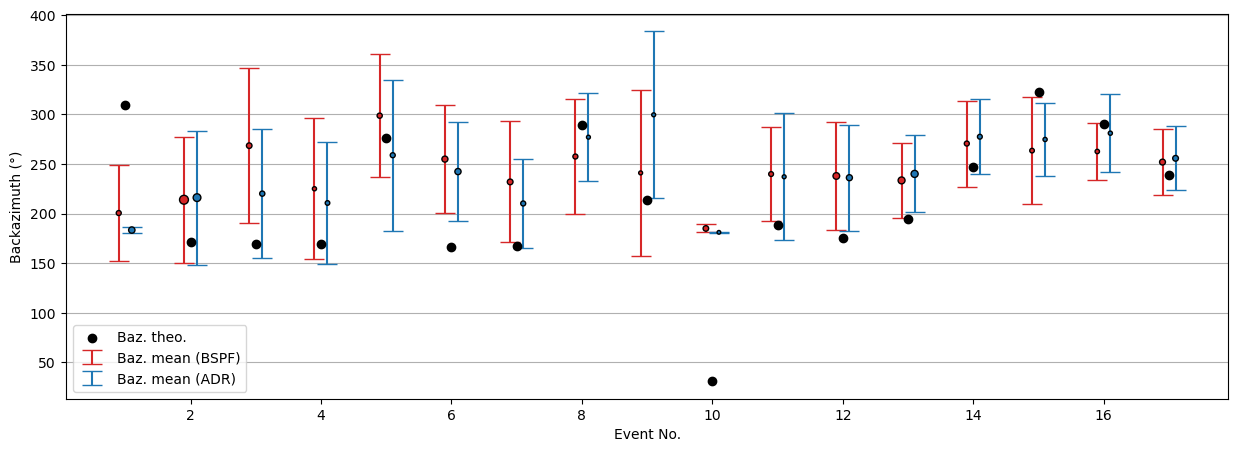

In [23]:
def __makeplot2():

    x = np.arange(1,len(data_baz.event_time)+1)

    fig = plt.figure(figsize=(15,5))
    plt.scatter(x, data_baz.baz_theo, c="k", zorder=3, label="Baz. theo.")

    plt.scatter(x-0.1, data_baz.baz_mean, s=data_baz.samples+5, c="tab:red", zorder=3, edgecolors="k")
    plt.errorbar(x-0.1, data_baz.baz_mean, yerr=data_baz.baz_std, ms=0, capsize=7, fmt="o", c="tab:red", zorder=2, label="Baz. mean (BSPF)")

    plt.scatter(x+0.1, data_baz_adr.baz_mean, s=data_baz_adr.samples+5, c="tab:blue", zorder=3, edgecolors="k")
    plt.errorbar(x+0.1, data_baz_adr.baz_mean, yerr=data_baz_adr.baz_std, ms=0, capsize=7, fmt="o", c="tab:blue", zorder=2, label="Baz. mean (ADR)")

    plt.xlabel("Event No.")
    plt.ylabel("Backazimuth (°)")
    plt.legend(loc=3)
    plt.grid(zorder=-1, axis="y")
    plt.show();

__makeplot2()

# fig.savefig(config['path_to_figs']+"BSPF_baz_events_bspf_adr.png", format="png", dpi=200)
# fig.savefig(config['path_to_figs']+f"BSPF_statistics_baz_comparison.png", dpi=200, bbox_inches='tight', pad_inches=0.05)

In [24]:
def __polar_plot2(data1):

    from numpy import deg2rad, radians

    r1 = data1.edist_km
    # m1 = data1.magnitude

    theta1 = deg2rad(data1.baz_mean)
    theta2 = deg2rad(data1.baz_theo)

    err = deg2rad(data1.baz_std)

    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8,8))

    ax.set_theta_offset(np.pi/2)
    ax.set_theta_direction(-1)

    m1 = ax.scatter(theta1, r1, s=40, c="tab:blue", marker="o", edgecolors="tab:blue", lw=1., zorder=3)
    m1.set_facecolor('none')

    ax.scatter(theta2, r1, s=40, c="darkgrey", lw=0.5, edgecolors="k", zorder=2)

    for i in range(len(r1)):
        ax.plot([theta1[i], theta2[i]], [r1[i], r1[i]], c="k", zorder=1, alpha=0.5, ls=":")

    ax.bar(theta1, r1, width=err/10, bottom=0.0, color="tab:blue", alpha=0.3)
    # ax.errorbar(theta1, r1, xerr=err, yerr=None, capsize=7, fmt="o", c="tab:red")

    ## station
    ax.scatter(0, 0, zorder=3, s=100, marker='^', c="r", lw=0.8, edgecolors="k")

#     ax.set_rmax(2)

#     ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
    ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
    ax.grid(True, zorder=0)

    ax.set_title("", va='bottom')
    plt.show();
    return fig

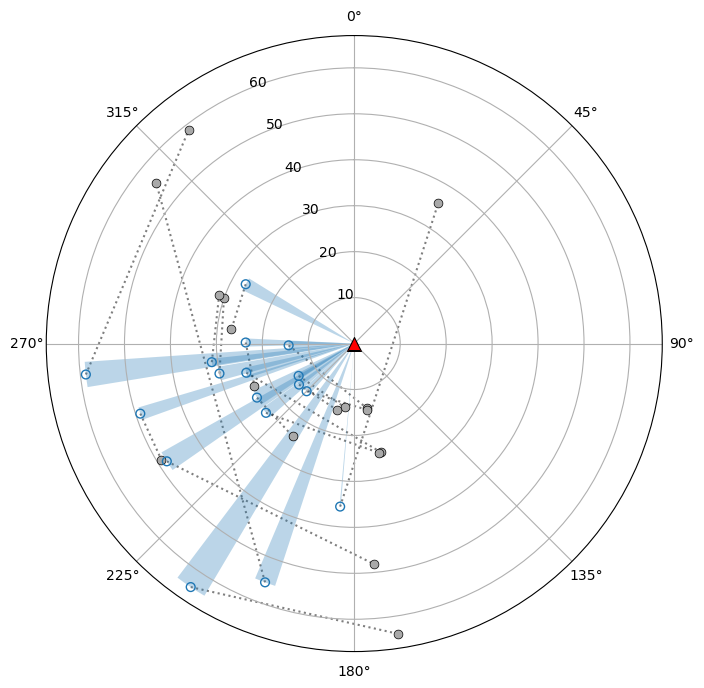

In [25]:
fig = __polar_plot2(data_baz)

# fig.savefig(config['path_to_figs']+"BSPF_baz_events_bspf_polar.png", format="png", dpi=200)
# fig.savefig(config['path_to_figs']+f"BSPF_statistics_baz_comparison_polar.png", dpi=200, bbox_inches='tight', pad_inches=0.05)